In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

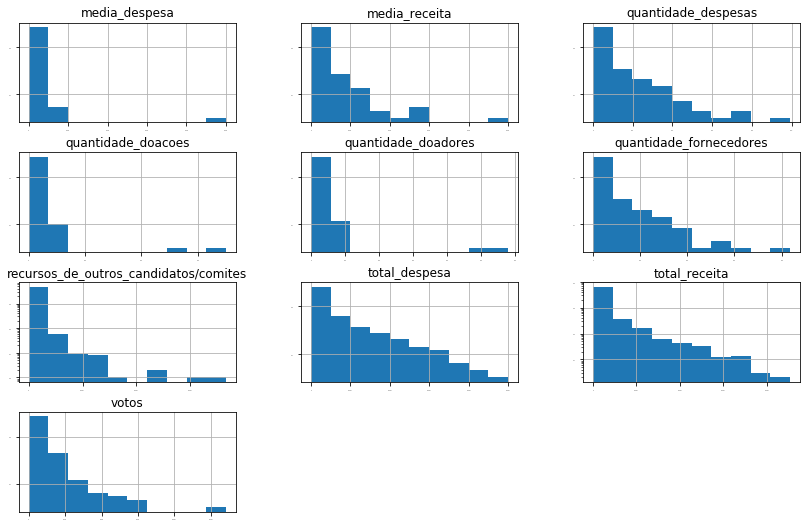

In [2]:
# Dados referentes as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010.
points = pd.read_csv("../data/eleicoes_2006_a_2010.csv")
matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
#histograma das variáveis numéricas
dist_feats = pd.DataFrame({ "quantidade_doacoes":points["quantidade_doacoes"],
                            "quantidade_doadores":points["quantidade_doadores"],
                            "total_receita":points["total_receita"],
                            "media_receita":points["media_receita"],
                            "recursos_de_outros_candidatos/comites":points["recursos_de_outros_candidatos/comites"],
                            "quantidade_despesas":points["quantidade_despesas"],
                            "quantidade_fornecedores":points["quantidade_fornecedores"],
                            "total_despesa":points["total_despesa"],
                            "media_despesa":points["media_despesa"],
                            "votos":points["votos"]
                          })
hits = dist_feats.hist(log=True, xlabelsize=0, ylabelsize=0)                

* Todos os atributos numéricos possuem viés para direita, neste caso é preciso normalizar-los
* Atributos irrelevantes como `sequencial_candidato` e `nome` podem ser removidos  
* Os dados de treino e validação correspondem as eleições de 2006 e 2010 e foram particionados em 75% e 25% respectivamente
* Valores faltantes foram substituídos pela mediana do respectivo atributo

In [3]:
#merge dos dados de 2006 a 2014
points = pd.concat((points, pd.read_csv("../data/eleicoes_2014.csv")))

#removendo variáveis irrelevantes
points = points.drop(columns=['sequencial_candidato', 'nome'])

#filling NA's with the median of the column:
points = points.fillna(points.median())

#selecionando atributos numéricos
numeric_feats = points.dtypes[points.dtypes != "object"].index

#normalizando variáveis numéricas
points[numeric_feats[1 :]] = np.log1p(points[numeric_feats[1:]])

#convertendo variáveis categóricas em dummy
points = pd.get_dummies(points)

#filtrando dados de 2006 e 2010
X = points.loc[points['ano'] != 2014].drop(columns=['votos'])
Y = points.loc[points['ano'] != 2014].votos

#particionando dados treino 75% e validação 25%
from sklearn.model_selection import train_test_split
train, validation, y_train, y_validation = train_test_split(X, Y)

Função para calcular o rmse na validação cruzada

In [4]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

### Regressão Linear Múltipla

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_linear = LinearRegression()
print ("Regressão Linear RMSE:{0}".format(rmse_cv(reg_linear).mean()))

Regressão Linear RMSE:215149444.61673132


### Ridge

O melhor alpha é 5.0, com rmse = 0.9273605391699903


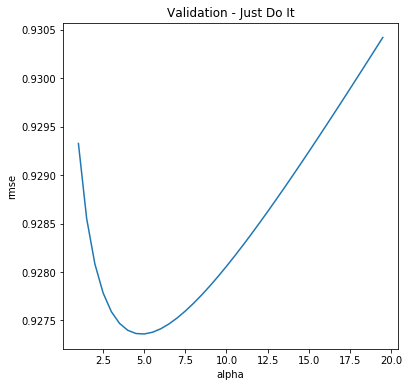

In [6]:
from sklearn.linear_model import Ridge
alphas_ridge = np.arange(1,20,0.5).tolist()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
print("O melhor alpha é {0}, com rmse = {1}".format(cv_ridge.idxmin(), cv_ridge.min()))

### Lasso

O melhor alpha é 0.0005, com rmse = 0.9271278466508438


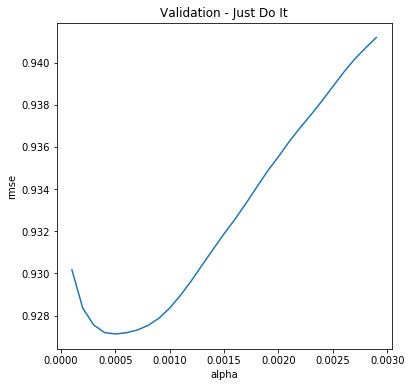

In [7]:
from sklearn.linear_model import Lasso
alphas_lasso = np.arange(0.0001,0.003,0.0001).tolist()
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter = 8000)).mean() 
            for alpha in alphas_lasso]
cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
print("O melhor alpha é {0}, com rmse = {1}".format(cv_lasso.idxmin(), cv_lasso.min()))

### KNN

A melhor quantidade de vizinhos é 28, com rmse = 0.9502389265157778


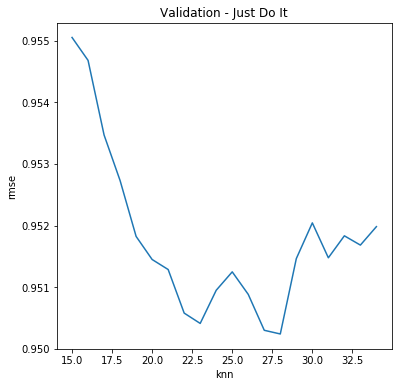

In [8]:
from sklearn.neighbors import KNeighborsRegressor
neighbors = np.arange(15,35,1).tolist()
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=neighbor)).mean() 
            for neighbor in neighbors]
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
cv_knn = pd.Series(cv_knn, index = neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("knn")
plt.ylabel("rmse")
print("A melhor quantidade de vizinhos é {0}, com rmse = {1}".format(cv_knn.idxmin(), cv_knn.min()))

### Decision Tree Regressor

A profundidade ideal é 6, com rmse = 0.9939618505178205


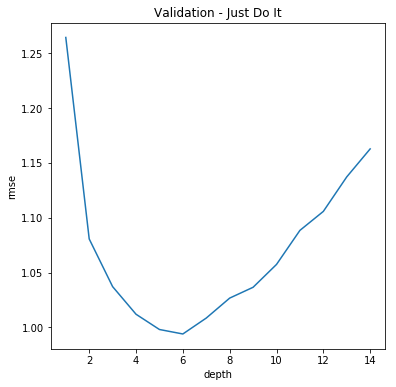

In [9]:
from sklearn.tree import DecisionTreeRegressor
depths = np.arange(1,15,1).tolist()
cv_treeregressor = [rmse_cv(DecisionTreeRegressor(max_depth = depth )).mean() 
            for depth in depths]
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
cv_treeregressor = pd.Series(cv_treeregressor, index = depths)
cv_treeregressor.plot(title = "Validation - Just Do It")
plt.xlabel("depth")
plt.ylabel("rmse")
print("A profundidade ideal é {0}, com rmse = {1}".format(cv_treeregressor.idxmin(), cv_treeregressor.min()))

# Resíduos versus Predições

In [10]:
# function to plot the residual vs predictions values of the model
def plot_res_vs_pred(model, x, y):
    y_pred = model.predict(x) #convertendo para escala original
    res = y - y_pred
    #printando rmse
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print("RMSE : {0}".format(rmse))
    #plotando resíduos
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    plt.plot(y_pred, res, 'k.', color='blue')
    plt.axhline(y = 0., color = 'r', linestyle = '-')
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")

### Ridge

RMSE : 0.9564653802676096


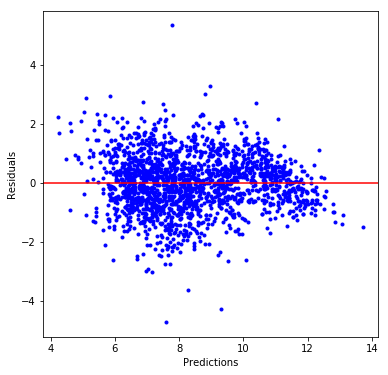

In [11]:
model_ridge = Ridge(alpha = cv_ridge.idxmin()).fit(train, y_train)
plot_res_vs_pred(model_ridge, validation, y_validation)

O modelo Ridge apresenta boa adequação ao problema, sua distribuição de resíduos é aleatória e em torno de 0, com rmse relativamente baixo.


### Lasso

RMSE : 0.9573405098686173


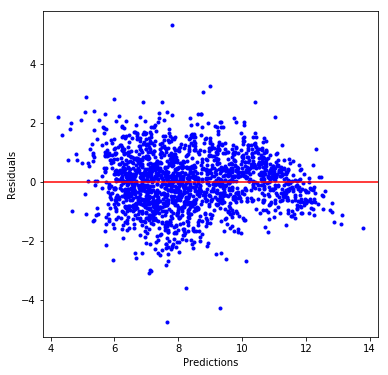

In [12]:
model_lasso = Lasso(alpha = cv_lasso.idxmin(), max_iter = 8000).fit(train, y_train)
plot_res_vs_pred(model_lasso, validation, y_validation)

O modelo lasso não apresenta padrões perceptíveis em sua distribuição que está distribuida em torno de 0, isso indica uma boa adequação do modelo ao problema em questão.

### KNN

RMSE : 0.9947986548102583


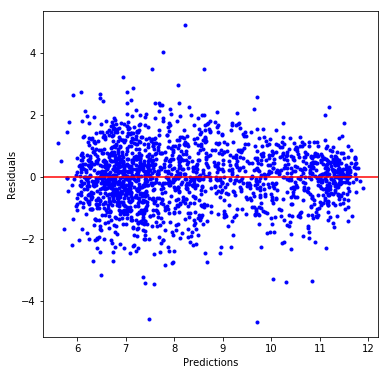

In [13]:
model_knn = KNeighborsRegressor(n_neighbors = cv_knn.idxmin()).fit(train, y_train)
plot_res_vs_pred(model_knn, validation, y_validation)

O KNN não apresenta padrões claros em sua distribuição de resíduos. Por possuir um rsme mais alto que Ridge e Lasso, ele não possui uma distribuição tão concentrada em torno de 0 quanto esses. Com isso ele é menos adequado ao problema do que os outros modelos já testados.

### Decision Tree Regressor

RMSE : 1.033860283842736


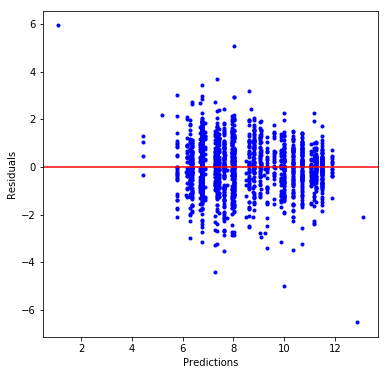

In [14]:
model_tree = DecisionTreeRegressor(max_depth = cv_treeregressor.idxmin()).fit(train, y_train)
plot_res_vs_pred(model_tree, validation, y_validation)

O plot dos resíduos para o modelo árvore de decisão apresenta padrões. Por se tratar de um modelo de classificação, para candidatos com dados relativamente parecidos o modelo preve a mesma quantidade de votos. Em outras palavras, ele cria categorias, faixas de valores para os votos, e associa a candidatos relativamente parecidos.<p> Assim, seu plot de resíduos e alto rmse indica uma inadequação do modelo ao problema.

# Previsão eleições 2014

In [15]:
#carregando dados de 2014
points_2014 = points.loc[points['ano'] == 2014]

### Ridge

RMSE : 1.6339587299691885


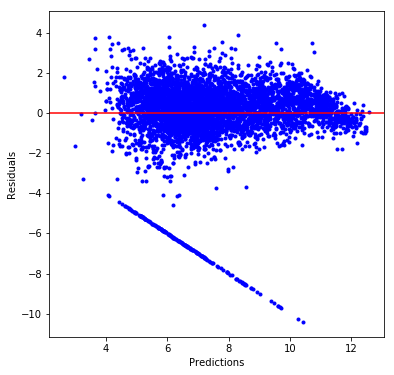

In [16]:
model_ridge = Ridge(alpha = cv_ridge.idxmin()).fit(points.drop(columns=['votos']), points.votos)
plot_res_vs_pred(model_ridge, points_2014.drop(columns=['votos']), points_2014.votos)

### Lasso

RMSE : 1.6402403719069159


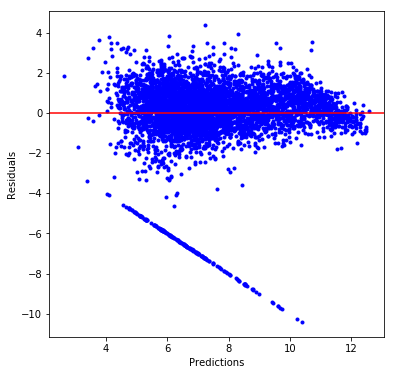

In [17]:
model_Lasso = Lasso(alpha = cv_lasso.idxmin()).fit(points.drop(columns=['votos']), points.votos)
plot_res_vs_pred(model_Lasso, points_2014.drop(columns=['votos']), points_2014.votos)

### KNN

RMSE : 1.640261437741432


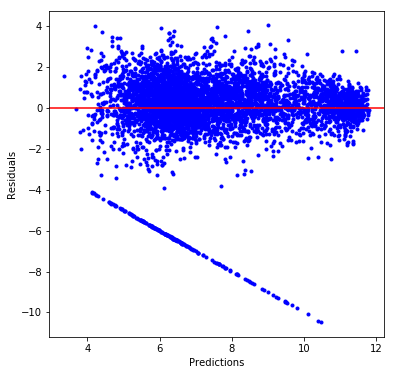

In [18]:
model_knn = KNeighborsRegressor(n_neighbors = cv_knn.idxmin()).fit(points.drop(columns=['votos']), points.votos)
plot_res_vs_pred(model_knn, points_2014.drop(columns=['votos']), points_2014.votos)

Considerando as eleições de 2014, os modelos tem uma distribuição bem parecida, sendo que ao comparar os rmse's o modelo Ridge apresenta ligeira vantagem. A reta que forma um padrão na parte inferior dos gráficos, pode ser explicar pela possibilidade desses pontos possuirem informações que não existiam nos dados de treino, deste modo os modelos não puderam aprender essas características.